In [1]:
import keras
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%matplotlib inline

Using TensorFlow backend.


In [2]:
DOMAIN = 'eclipse'
DIR = 'data/processed/{}'.format(DOMAIN)
DATASET = os.path.join('data/normalized/{}'.format(DOMAIN), '{}.csv'.format(DOMAIN))
DIR_PAIRS = 'data/normalized/{}'.format(DOMAIN)

In [3]:
df_train_pair = pd.read_csv(os.path.join(DIR_PAIRS, 'eclipse_pairs.csv'))
df = pd.read_csv(os.path.join(DIR_PAIRS, 'eclipse.csv'))

In [4]:
def create_bucket(data):
    print("Creating the buckets...")
    buckets = {}
    # Reading the buckets
    df_buckets = data[data['dup_id'] == '[]']
    loop = tqdm(total=df_buckets.shape[0])
    for row in df_buckets.iterrows():
        name = row[1]['bug_id']
        buckets[name] = set()
        buckets[name].add(name)
        loop.update(1)
    loop.close()
    # Fill the buckets
    df_duplicates = data[data['dup_id'] != '[]']
    loop = tqdm(total=df_duplicates.shape[0])
    for row_bug_id, row_dup_id in df_duplicates[['bug_id', 'dup_id']].values:
        bucket_name = int(row_dup_id)
        dup_id = row_bug_id
        while bucket_name not in buckets:
            query = df_duplicates[df_duplicates['bug_id'] == bucket_name]
            bucket_name = int(query['dup_id'])
        buckets[bucket_name].add(dup_id)
        loop.update(1)
    loop.close()
    return buckets

In [5]:
buckets = create_bucket(df)

Creating the buckets...


In [6]:
issues_by_buckets = {}
for bucket in tqdm(buckets):
    issues_by_buckets[bucket] = bucket
    for issue in np.array(buckets[bucket]).tolist():
        issues_by_buckets[issue] = bucket

In [7]:
buckets_at_least_2_dups = [bucket for bucket in buckets if len(buckets[bucket]) > 1]
buckets_alone = [bucket for bucket in buckets if len(buckets[bucket]) <= 1]

In [8]:
print("buckets_at_least_2_dups:", len(buckets_at_least_2_dups))
print("buckets_alone:", len(buckets_alone))

buckets_at_least_2_dups: 24414
buckets_alone: 297122


In [9]:
issues_by_buckets[214181], buckets[issues_by_buckets[214181]]

(214181, {214181})

#### Example 1

In [10]:
buckets[210304]

{210304, 214411, 216663, 216725, 218239}

In [11]:
df[df['bug_id'].isin([214411, 210304, 216725, 216725, 216663, 218239])]

,bug_id,bug_severity,bug_status,component,creation_ts,delta_ts,description,dup_id,priority,product,resolution,short_desc,version
194060,210304,normal,VERIFIED,IDE,2007-11-19 16:31:00 -0500,2008-02-07 16:11:08 -0500,+++ This bug was initially created as a clone ...,[],P3,Platform,FIXED,[Navigator] resourceFilters incorrectly read f...,3.3.1
197893,214411,normal,RESOLVED,IDE,2008-01-04 17:47:00 -0500,2009-10-01 09:36:04 -0400,I just started using Eclipse version 3.3.1.1 (...,210304,P3,Platform,DUPLICATE,ResourceNavigator filters appear to be totally...,3.3.1
197894,214411,normal,RESOLVED,IDE,2008-01-04 17:47:00 -0500,2009-10-01 09:36:04 -0400,I just started using Eclipse version 3.3.1.1 (...,[],P3,Platform,NDUPLICATE,ResourceNavigator filters appear to be totally...,3.3.1
200426,216663,normal,RESOLVED,IDE,2008-01-25 20:49:00 -0500,2009-10-01 09:36:04 -0400,Build ID: M20071023-1652\n\nSteps To Reproduce...,210304,P3,Platform,DUPLICATE,Navigator Filters dialog is empty,3.3.1
200472,216725,normal,RESOLVED,IDE,2008-01-28 04:06:00 -0500,2009-10-01 09:36:04 -0400,Build ID: M20071023-1652\n\nSteps To Reproduce...,210304,P3,Platform,DUPLICATE,resourceFilters extension point doesn't work,3.3.1
201797,218239,normal,RESOLVED,UI,2008-02-07 14:54:00 -0500,2008-02-07 16:11:08 -0500,Build ID: M20071023-1652\n\nSteps To Reproduce...,210304,P3,Platform,DUPLICATE,[Navigator View] Filters dialog is empty when...,3.3.1


#### Example 2

In [12]:
buckets[119056]

{119056, 119285, 119619, 119712, 119845, 120183}

In [13]:
df[df['bug_id'].isin(buckets[119056])]

,bug_id,bug_severity,bug_status,component,creation_ts,delta_ts,description,dup_id,priority,product,resolution,short_desc,version
112218,119056,normal,VERIFIED,CVS,2005-12-02 11:50:00 -0500,2005-12-13 15:13:37 -0500,"I20051130-1215\n\nWhen comparing, tagging or r...",[],P3,Platform,FIXED,Duplicate entries in compare/replace with bran...,3.2
112425,119285,normal,RESOLVED,Team,2005-12-05 13:38:00 -0500,2005-12-07 15:12:06 -0500,I20051130-1215\n*I have a java class in my wor...,119056,P3,Platform,DUPLICATE,Replace with uncommitted changes dialog shows ...,3.2
112736,119619,normal,RESOLVED,Team,2005-12-07 07:30:00 -0500,2005-12-09 09:07:33 -0500,I20051206\n\n1. Check out a Java project from ...,119056,P3,Platform,DUPLICATE,Replace with latest propose the same .java fil...,3.1
112812,119712,normal,RESOLVED,Team,2005-12-07 14:26:00 -0500,2005-12-07 15:12:06 -0500,Build: I-20051206 (and even the one from the w...,119285,P3,Platform,DUPLICATE,seeing double,3.1
112941,119845,normal,RESOLVED,Team,2005-12-08 07:01:00 -0500,2005-12-08 10:13:29 -0500,Take a project with some local changes you wan...,119056,P3,Platform,DUPLICATE,Replace with dialog shows projects multiple times,3.2
113259,120183,normal,RESOLVED,Team,2005-12-09 16:39:00 -0500,2005-12-09 16:52:38 -0500,See attached screenshot.\n\nThe dialog title i...,119056,P3,Platform,DUPLICATE,"Duplicate entries in ""Replace with uncommitted...",3.2


#### Example 3

In [14]:
buckets[288347]

{213528, 214971, 288347}

In [15]:
df[df['bug_id'].isin([214971, 288347, 213528])]

,bug_id,bug_severity,bug_status,component,creation_ts,delta_ts,description,dup_id,priority,product,resolution,short_desc,version
196816,213528,enhancement,RESOLVED,Jira,2007-12-19 15:58:00 -0500,2009-09-02 18:37:37 -0400,-- Created from Comment --\nURL: https://bugs....,288347,P2,Mylyn,DUPLICATE,only submit comment if none of the attributes ...,unspecified
198879,214971,normal,RESOLVED,Jira,2008-01-10 17:52:00 -0500,2009-09-17 19:45:23 -0400,Is unable to reassign a tasks through the acti...,288347,P3,Mylyn,DUPLICATE,unable to reassign tasks if no permissions to ...,2.2
198880,214971,normal,RESOLVED,Jira,2008-01-10 17:52:00 -0500,2009-09-17 19:45:23 -0400,Is unable to reassign a tasks through the acti...,[],P3,Mylyn,NDUPLICATE,unable to reassign tasks if no permissions to ...,2.2
260795,288347,enhancement,RESOLVED,Jira,2009-09-02 08:19:00 -0400,2009-09-24 05:37:43 -0400,User-Agent: Mozilla/5.0 (Macintosh; U; I...,[],P2,Mylyn,FIXED,only update comment or reassign if this is the...,3.2


### Ploting buckets after training

In [16]:
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import sys
from annoy import AnnoyIndex
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%matplotlib inline

In [17]:
from methods.baseline import Baseline
from methods.experiments import Experiment
from methods.evaluation import Evaluation
from methods.retrieval import Retrieval

In [18]:
MAX_SEQUENCE_LENGTH_T = 100 # 100
MAX_SEQUENCE_LENGTH_D = 500 # 500
EMBEDDING_DIM = 300
MAX_NB_WORDS = 20000

In [34]:
# Domain to use
DOMAIN = 'netbeans'
METHOD = 'propose_master_triplet_loss'
# Dataset paths
DIR = 'data/processed/{}'.format(DOMAIN)
DIR_PAIRS = 'data/normalized/{}'.format(DOMAIN)
DATASET = os.path.join('data/normalized/{}'.format(DOMAIN), '{}.csv'.format(DOMAIN))
# Glove embeddings
GLOVE_DIR='data/embed'
# Save model
SAVE_PATH = '{}_feature@number_of_epochs@epochs_64batch({})'.format(METHOD, DOMAIN)
SAVE_PATH_FEATURE_1_EPOCH = '{}_feature_1epochs_64batch({})'.format(METHOD, DOMAIN)
SAVE_PATH_FEATURE = '{}_feature_@number_of_epochs@epochs_64batch({})'.format(METHOD, DOMAIN)

# Extract CORPUs
EXTRACT_CORPUS = False

In [20]:
baseline = Baseline(DIR, DATASET, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D)
evaluation = Evaluation(verbose=0)
retrieval = Retrieval()
experiment = Experiment(baseline, evaluation)

In [21]:
experiment.set_retrieval(retrieval, baseline, DOMAIN)

Creating the buckets...


In [22]:
experiment.load_ids()
len(baseline.bug_ids)

Reading bug ids


216715

In [23]:
%%time

experiment.load_bugs()
len(baseline.sentence_dict)


CPU times: user 1min 24s, sys: 2.4 s, total: 1min 26s
Wall time: 1min 25s


In [24]:
issues_by_buckets = experiment.get_buckets_for_bugs()

In [25]:
%%time

experiment.prepare_dataset(issues_by_buckets, path_train='train_chronological', path_test='test_chronological')
# Read and create the test queries duplicates
retrieval.create_queries()

Reading train data
Reading bug ids
CPU times: user 2min 39s, sys: 7.09 ms, total: 2min 39s
Wall time: 2min 39s


In [26]:
bug_train_ids = experiment.get_train_ids(baseline.train_data)

In [233]:
from sklearn.manifold import TSNE
import random

def plot_2d(test_labels, tsne_features, categories, colors=None):
    if colors == None:
        colors = [(random.uniform(.25, .75), random.uniform(.5, 1), random.uniform(.25, .75)) for i in enumerate(test_labels)]
    plt.figure(figsize=(10, 10))
    test_labels = np.asarray(test_labels)
    for c_color, c_label in zip(colors, categories):
        plt.scatter(tsne_features[np.where(test_labels == c_label), 0],
                    tsne_features[np.where(test_labels == c_label), 1],
                    marker='o',
                    color=c_color,
                    linewidth='1',
                    alpha=0.8,
                    label=c_label)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('t-SNE on Buckets')
    plt.legend(loc='best')
    #plt.savefig('clothes-dist.png')
    plt.show(block=False)
    if colors != None:
        return colors

def create_features(x_test_features):
    tsne_obj = TSNE(n_components=2,
                            init='pca',
                            random_state=101,
                            method='barnes_hut',
                            n_iter=500,
                            verbose=0)
    tsne_features = tsne_obj.fit_transform(x_test_features)
    return tsne_features

In [35]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
model = experiment.get_model_vectorizer(path=SAVE_PATH_FEATURE.replace('@number_of_epochs@', '100'))

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [38]:
model_1_epoch = experiment.get_model_vectorizer(path=SAVE_PATH_FEATURE_1_EPOCH)

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [39]:
buckets_2_dups = [bucket for bucket in retrieval.buckets if len(retrieval.buckets[bucket]) == 2]
buckets_biggest_2_dups = [bucket for bucket in retrieval.buckets if len(retrieval.buckets[bucket]) > 2]
buckets_3_dups = [bucket for bucket in retrieval.buckets if len(retrieval.buckets[bucket]) == 3]
buckets_5_dups = [bucket for bucket in retrieval.buckets if len(retrieval.buckets[bucket]) == 5]
buckets_between_5_and_10_dups = [bucket for bucket in retrieval.buckets if len(retrieval.buckets[bucket]) > 5 and len(retrieval.buckets[bucket]) <= 10]
buckets_biggest_10_dups = [bucket for bucket in retrieval.buckets if len(retrieval.buckets[bucket]) > 10]

In [40]:
len(buckets_2_dups), len(buckets_3_dups), len(buckets_5_dups), len(buckets_between_5_and_10_dups), len(buckets_biggest_10_dups)

(13589, 3411, 628, 897, 228)

In [109]:
import numpy as np

def create_tsne_vector(model):
    test_features = []
    title_data, desc_data, info_data = [], [], []
    categories = []
    bucket_labels = set()

    for row  in bucket_dups_selected:
        bug_id, bucket_id = row
        # bucket and dups
        if bug_id not in baseline.bug_set: continue
        if bug_id in retrieval.buckets:
            label = 'duplicado_de_{}'.format(bucket_id)
            categories.append(label)
            bucket_labels.add(label)
        else:
            dup_label = 'duplicado_de_{}'.format(bucket_id)
            categories.append(dup_label)
            bucket_labels.add(dup_label)
        bug = baseline.bug_set[bug_id]
        title_data.append(bug['title_word'])
        desc_data.append(bug['description_word'])
        info_data.append(experiment.retrieval.get_info(bug))

    bucket_labels = list(bucket_labels)    
    test_features = model.predict([ np.array(title_data), np.array(desc_data), np.array(info_data) ])
    return bucket_labels, test_features, categories

### Select random buckets

In [234]:
selected_buckets = [ 47708, 228156, 132573, 132662, 207563]
# [226761, 211165,  60740, 172436, 160273]
# [146677, 118038, 207060, 236101,  35870] - best
# [ 47708, 228156, 132573, 132662, 207563] - best
# selected_buckets = np.random.choice(buckets_biggest_10_dups, 5)

In [235]:
selected_buckets

[47708, 228156, 132573, 132662, 207563]

In [236]:
bucket_dups_selected = []
for bucket in selected_buckets:
    bucket_dups_selected += [(bug_id, bucket) for bug_id in retrieval.buckets[bucket]]

### Model trained with 1 epoch

In [237]:
bucket_labels_1epoch, test_features_1epoch, categories_1epoch = create_tsne_vector(model_1_epoch)

### Select random buckets

In [238]:
bucket_labels, test_features, categories = create_tsne_vector(model)

### Visualizing bucket space

Plota um conjunto de duplicados pintando o mestre de uma cor e os seus duplicados de outra

### 1 epoch

In [239]:
test_features_1epoch.shape, len(categories_1epoch), len(bucket_labels_1epoch)

((98, 900), 98, 5)

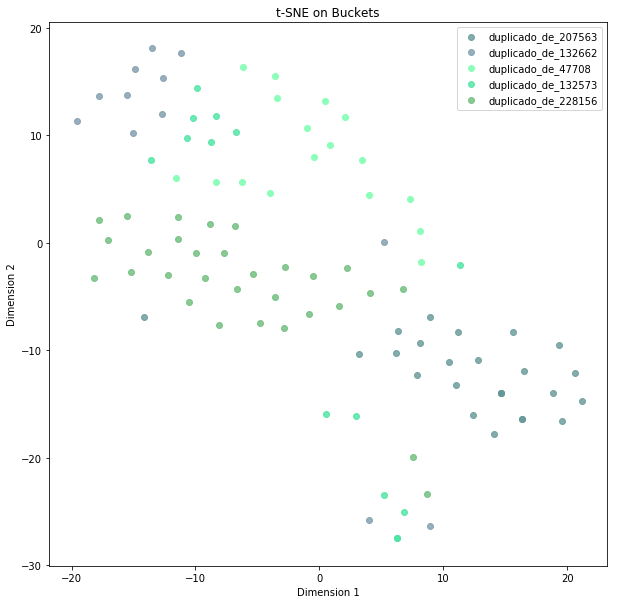

In [240]:
tsne_features_1epoch = create_features(test_features_1epoch)

colors = plot_2d(categories_1epoch, tsne_features_1epoch, bucket_labels_1epoch)

### 100 epochs

In [241]:
test_features.shape, len(categories), len(bucket_labels)

((98, 900), 98, 5)

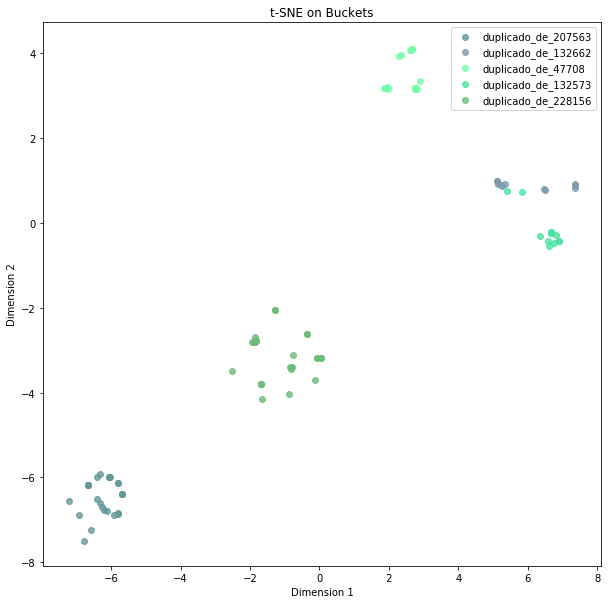

In [242]:
tsne_features = create_features(test_features)

_ = plot_2d(categories, tsne_features, bucket_labels, colors)